In [1]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from joblib import dump, load
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from ipywidgets import HBox, widgets, Layout, Button
from IPython.display import display, HTML
import base64

from board_utils import *

In [2]:
assets_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
single_path = os.path.join(assets_path, 'kgames_sample.pgn')
#games = load_pgns(single_path, 1000)
#games = games_from_drive()

In [3]:
try:
    all_board_csr_matrix = load('fen_csr_matrix_1k.joblib')
    game_lengths = load('game_lengths_1k.joblib')
except:
    game_csr_matrices = [game_to_csr_matrix(game) for game in games]
    game_lengths = [mat.shape[0] for mat in game_csr_matrices]
    all_board_csr_matrix = vstack(game_csr_matrices)
    #dump(all_board_csr_matrix, 'fen_csr_matrix.joblib')
    #dump(game_lengths, 'game_lengths_1k.joblib')

In [4]:
cumulative_lengths = np.cumsum(game_lengths)
fen_idf_matrix_norm = apply_norm_and_idf(all_board_csr_matrix)

In [5]:
n_components = 100
try:
    svd = load('svd_model.joblib')
    fens_reduced = svd.transform(fen_idf_matrix_norm)
except:
    svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
    fens_reduced = svd.fit_transform(fen_idf_matrix_norm)
    #dump(svd, 'svd_model.joblib')

C:\Users\Jim\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
def fen_to_img_html(fen, size=500):
    board = chess.Board(fen)
    svg = chess.svg.board(board, size=size)
    svg_bytes = svg.encode('utf-8')
    b64_svg = base64.b64encode(svg_bytes).decode('utf-8')
    return f'<img src="data:image/svg+xml;base64,{b64_svg}" style="max-width:100%; height: auto;"/>'

def get_fen_string(index):
    return vector_to_fen(all_board_csr_matrix[index].toarray()[0])

def index_to_endgame_status(ind):
    piece_materials = all_board_csr_matrix[ind].toarray()[0][-11:-2]
    piece_materials[4] = 0
    if sum(piece_materials) < 4:
        return 'endgame'
    else:
        return '' 

def game_ind_from_pos_ind(position_index):
    return np.searchsorted(np.cumsum(game_lengths), position_index, side='right')

lightest_color = '#cdb688'
darkest_color = '#c5a771'
walnut = [[0, lightest_color],[1, darkest_color]]

pca_3d = PCA(n_components=3)
reduced_data_pca_3d = pca_3d.fit_transform(fens_reduced)

original_size = 5
original_opacity = 0.1

#hover_text_3d = [f'FEN: {get_fen_string(i)}' for i in range(len(reduced_data_pca_3d))]
hover_text_3d = [f'{index_to_endgame_status(i)}' for i in range(len(reduced_data_pca_3d))]

fig = go.Figure(data=[go.Scatter3d(
    x=reduced_data_pca_3d[:, 0],
    y=reduced_data_pca_3d[:, 1],
    z=reduced_data_pca_3d[:, 2],
    mode='markers',
    marker=dict(
        size=original_size,
        opacity=original_opacity,
        color=list(range(len(reduced_data_pca_3d))),
        colorscale=walnut,
    ),
    hoverinfo='text',
    text=hover_text_3d
)])

fig.update_layout(
    width=500,
    height=500,
    scene=dict(
        xaxis_title='PC X',
        yaxis_title='PC Y',
        zaxis_title='PC Z'
    ),
    margin=dict(r=0, b=0, l=0, t=0)
)

fig_widget = go.FigureWidget(fig)
chessboard_display = widgets.HTML()

def update_chessboard(trace, points, _):
    if points.point_inds:
        index = points.point_inds[0]
        game_index = game_ind_from_pos_ind(index)

        fen = get_fen_string(index)
        chessboard_display.value = fen_to_img_html(fen)

        game_start_index = np.cumsum(game_lengths)[game_index - 1] if game_index > 0 else 0
        game_end_index = np.cumsum(game_lengths)[game_index]

        size = [3*original_size if game_start_index <= i < game_end_index else 0 for i in range(len(reduced_data_pca_3d))]

        with fig_widget.batch_update():
            fig_widget.data[0].marker.size = size
            fig_widget.data[0].marker.opacity = 1
            fig_widget.data[0].marker.line.width = 0.01
            fig_widget.data[0].marker.line.color = 'black'

def revert_to_original(_):
    with fig_widget.batch_update():
        fig_widget.data[0].marker.size = [2*original_size] * len(reduced_data_pca_3d)
        fig_widget.data[0].marker.opacity = original_opacity
        fig_widget.data[0].marker.line.width = 0

revert_button = Button(description="Revert to Original")
revert_button.on_click(revert_to_original)

for trace in fig_widget.data:
    trace.on_hover(update_chessboard)

widgets_layout = HBox([fig_widget, chessboard_display, revert_button], layout=Layout(justify_content='space-between', padding='100px'))
display(widgets_layout)

    'data': [{'hoverinfo': 'text',
              'marker': {'color': [0, 1, 2, .…

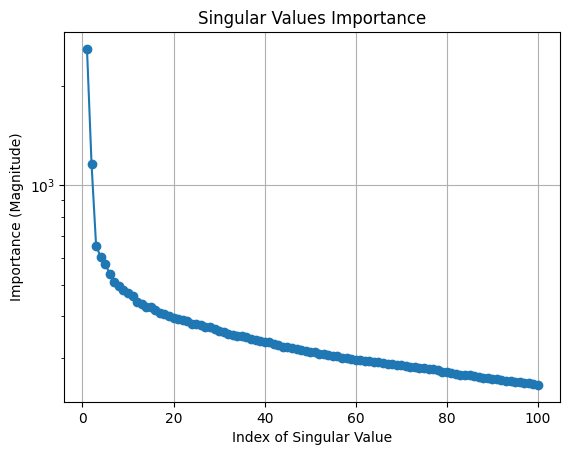

In [7]:
plt.plot(range(1,n_components+1), svd.singular_values_, marker='o')
plt.title('Singular Values Importance')
plt.xlabel('Index of Singular Value')
plt.ylabel('Importance (Magnitude)')
plt.yscale('log')
plt.grid(True)
plt.show()

In [8]:
num_top_components = 10
num_top_features = 30
for i, component in enumerate(svd.components_[:num_top_components]):
    feature_indices = np.argsort(np.abs(component))[::-1][:num_top_features]
    print(f"Top {num_top_features} features for component {i+1}:")
    for feature_index in feature_indices:
        importance = np.abs(component[feature_index])
        feature_name = index_to_piece_square(feature_index)
        print(f"{feature_name}: Importance {importance}")
    print()

Top 30 features for component 1:
White Rook on a1: Importance 0.15787924182183355
Black Rook on a8: Importance 0.15767615239308075
Castle_Black_Kingside: Importance 0.15273061967113175
Castle_Black_Queenside: Importance 0.15258306801896976
Black King on e8: Importance 0.15252728640124372
Black Rook on h8: Importance 0.15185593240628414
Black Queen on d8: Importance 0.15083789626821212
Castle_White_Kingside: Importance 0.1499624727135209
White King on e1: Importance 0.1497104129530384
Castle_White_Queenside: Importance 0.14969924720907277
White Queen on d1: Importance 0.14945249811610864
White Rook on h1: Importance 0.14913410812325348
White Pawn on b2: Importance 0.1484201811223978
Black Pawn on b7: Importance 0.1478844963692377
White Pawn on a2: Importance 0.14735469357296485
White Pawn on h2: Importance 0.14689905480687432
Black Pawn on a7: Importance 0.1467882068640893
Black Pawn on h7: Importance 0.1465380934474257
Black Pawn on f7: Importance 0.1462759174844365
White Pawn on f2: I

In [9]:
#query_fen = 'rnb2b1r/2Nnkppp/p2pp3/8/PPBN1P2/2p3Pq/4Q2P/R3K1R1 w Q - 1 17' #wild opening
#query_fen = 'rnbq1rk1/pp2ppbp/3p1np1/8/3NP3/2N1BP2/PPP3PP/R2QKB1R w KQ - 1 8' #dragon
#query_fen = 'r1bq1rk1/ppp2pbp/2np1np1/4p3/2PPP3/2N2N2/PP2BPPP/R1BQ1RK1 w - - 2 8' #kid
query_fen = '6k1/5p2/1r2p1p1/3p1n2/3P3p/1P1R3P/4NPP1/6K1 b - - 2 36' #knight rook endgame
query_array = board_to_array(chess.Board(fen=query_fen))
transformed_query_array = apply_query_transformations(query_array, all_board_csr_matrix)
query_array_reduced = svd.transform(transformed_query_array.reshape(1, -1))

In [10]:
k=25

norm_X_reduced = fens_reduced / np.linalg.norm(fens_reduced, axis=1, keepdims=True)
norm_query_vector_reduced = query_array_reduced / np.linalg.norm(query_array_reduced)

cos_similarities = 1 - cdist(norm_X_reduced, norm_query_vector_reduced, metric='cosine')
cos_similarities = cos_similarities.flatten()

top_k_indices = np.argsort(cos_similarities)[-k:][::-1]

cos_similarities[top_k_indices]

array([0.69082594, 0.68181013, 0.67585911, 0.67579037, 0.67559051,
       0.67496666, 0.67245791, 0.67108543, 0.66242791, 0.66151025,
       0.65062626, 0.64546794, 0.63987624, 0.61974761, 0.61768083,
       0.61132331, 0.60722563, 0.60655932, 0.60601865, 0.60469337,
       0.60423354, 0.60357491, 0.60049026, 0.59983165, 0.59681477])

6k1/5p2/1r2p1p1/3p1n2/3P3p/1P1R3P/4NPP1/6K1 b - - 0 1


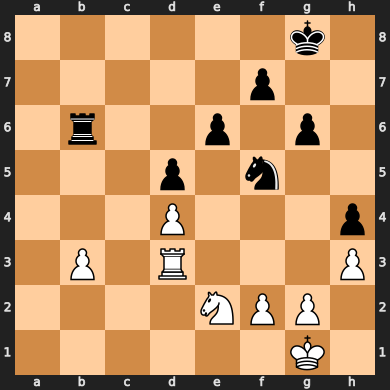

----------------------------------------------------------------
6k1/p3Bp1p/4p1p1/8/2P1q3/1P5P/r5P1/5QK1 b - - 0 1


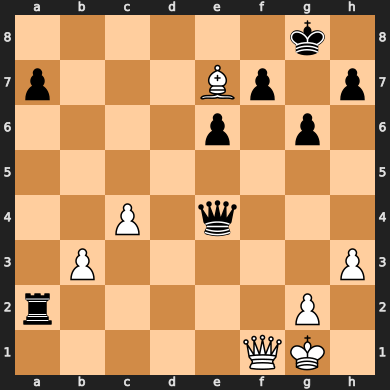

6k1/p4p1p/4p1p1/2B5/2P1q3/1P5P/P2r2P1/5QK1 b - - 0 1


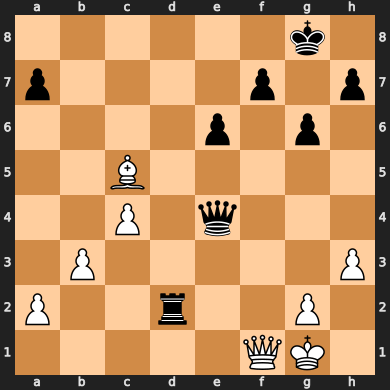

6k1/p3Bp1p/4p1p1/8/2P5/1P3q1P/3r2P1/6K1 w - - 0 1


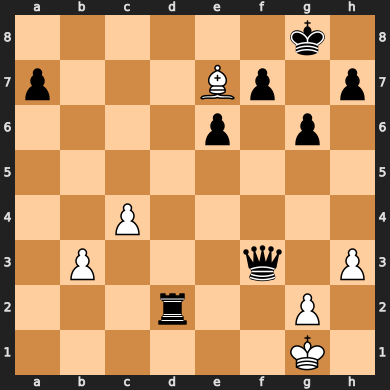

6k1/p4p1p/4p1p1/2B5/2P1q3/1P5P/r5P1/5QK1 w - - 0 1


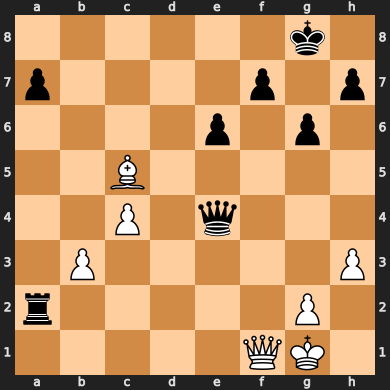

6k1/p3Bp1p/4p1p1/8/2P5/1P2q2P/r5P1/5QK1 w - - 0 1


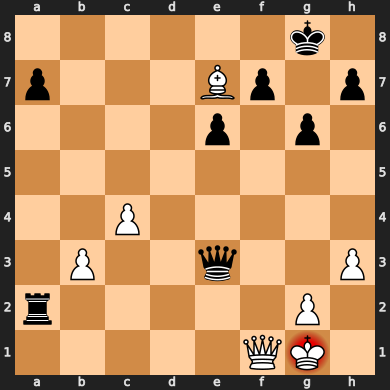

6k1/p3Bp1p/4p1p1/8/2P2q2/1P5P/5rP1/3Q2K1 b - - 0 1


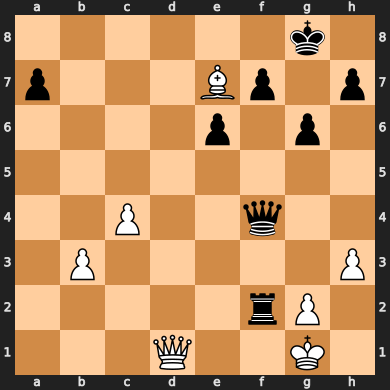

R5k1/5p2/4p1p1/3p2rn/3P3p/5P2/4NK2/8 b - - 0 1


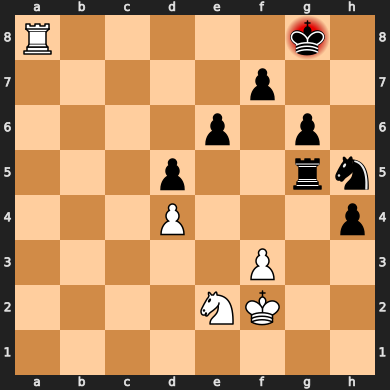

6k1/5p2/4p1p1/3p3n/R2P3p/5Pr1/4NK2/8 b - - 0 1


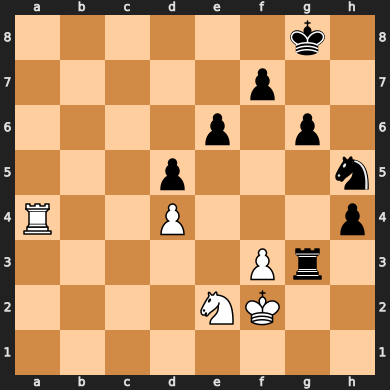

6k1/5p2/4p1p1/3p2rn/R2P3p/5P2/4NK2/8 w - - 0 1


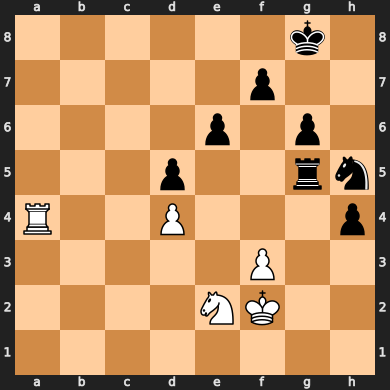

6k1/p3Bp1p/4p1p1/8/2P2q2/1P5P/3r2P1/3Q2K1 w - - 0 1


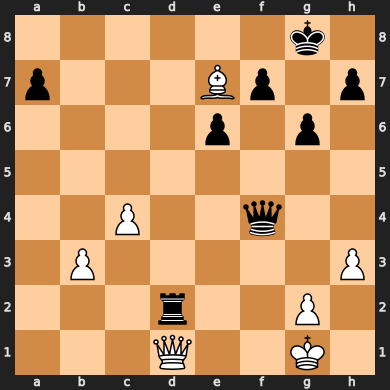

r1r3k1/6pp/p5n1/5n2/Q7/1PP4P/4NPP1/R5K1 w - - 0 1


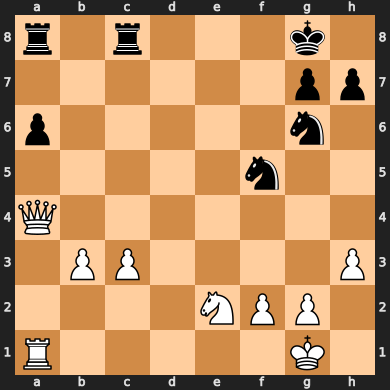

6k1/1pp2p2/1p1b2p1/8/r4P2/1P5P/3RN3/6K1 b - - 0 1


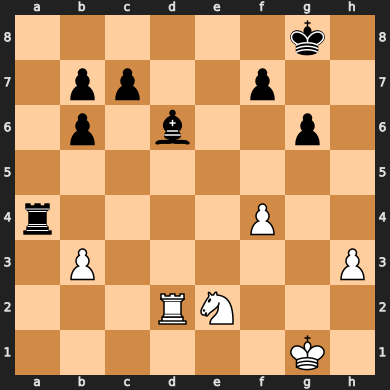

6k1/1pp2p2/1p1b2p1/8/1r3P2/1P5P/3RN3/6K1 w - - 0 1


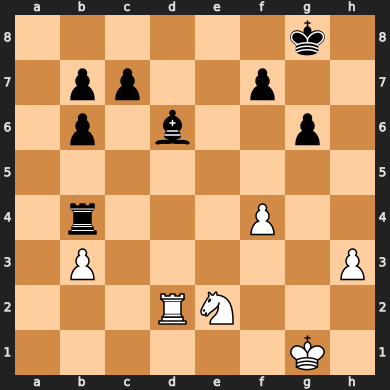

6k1/1pp2p2/1p4p1/4b3/r4P2/7P/1P1RN3/6K1 b - - 0 1


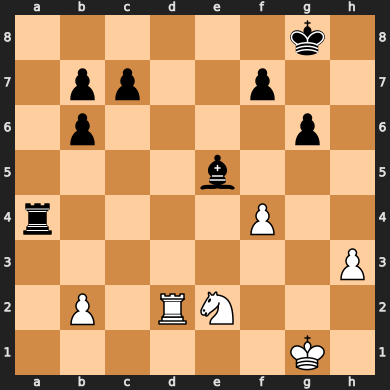

6k1/p3Bp1p/4p1p1/8/2P5/1P2q2P/r5PK/5Q2 b - - 0 1


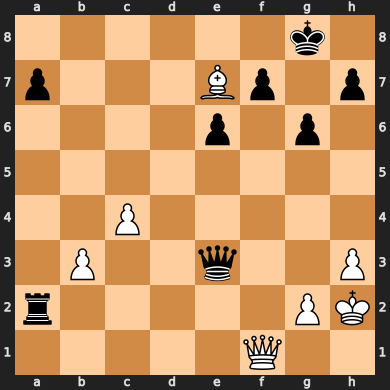

r5k1/1pp2p2/1p4p1/4b3/B7/5P1P/1P1RN3/6K1 b - - 0 1


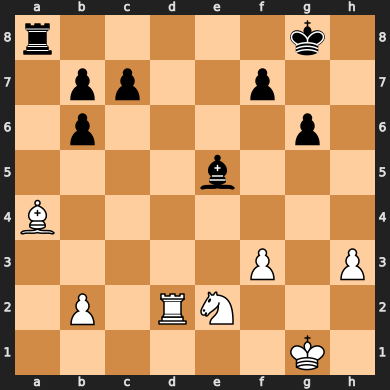

6k1/1pp2p2/1p4p1/4b3/r7/5P1P/1P1RN3/6K1 w - - 0 1


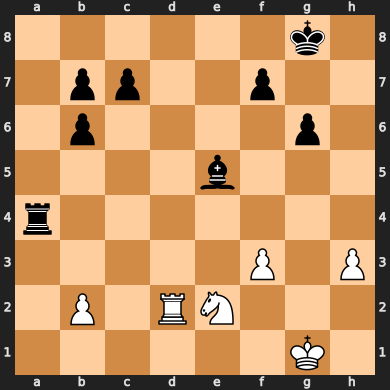

6k1/p3Bp1p/4p1p1/8/2P5/1P3P1P/3r4/6K1 b - - 0 1


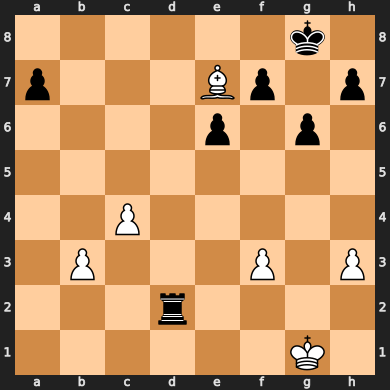

6k1/ppp2p1p/6p1/1q1p4/2P5/1P5P/2Q2PP1/6K1 b - - 0 1


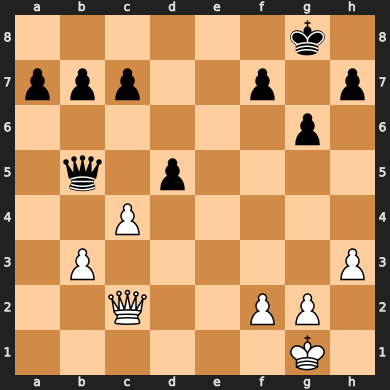

r5k1/1pp2p2/1pb3p1/4b3/P7/1B3p1P/1P1RN1P1/6K1 w - - 0 1


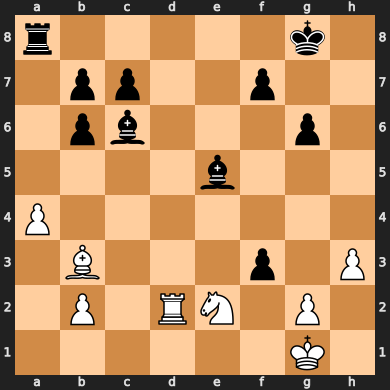

6k1/p3Bp1p/4p1p1/8/2P5/1P2q2P/5rPK/3Q4 b - - 0 1


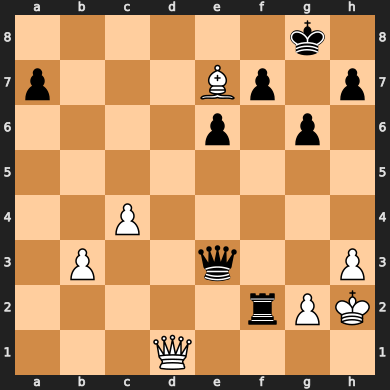

6k1/p3Bp1p/4p1p1/8/2P5/1P2q2P/5rPK/5Q2 w - - 0 1


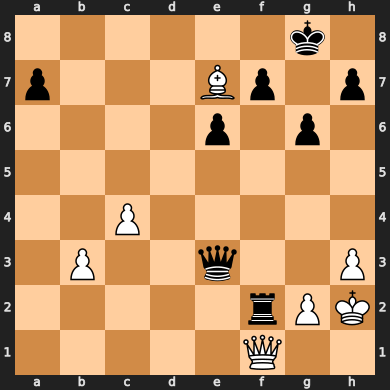

1r2r1k1/5p1p/pq3bp1/1pRp4/3P4/PP6/3QNPPP/3R2K1 b - - 0 1


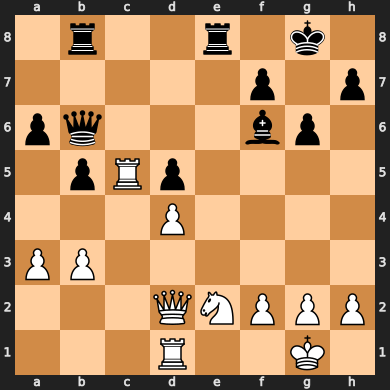

6k1/ppp2p1p/6p1/1q1p4/8/1PP4P/2Q2PP1/6K1 w - - 0 1


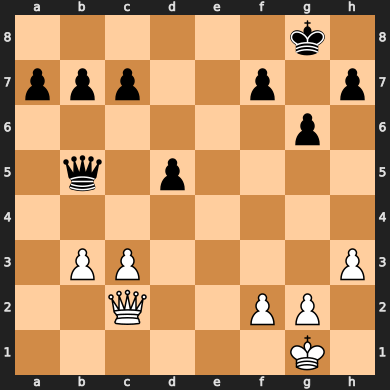

6k1/ppp2p1p/6p1/1P1p4/2q5/1PP4P/2Q2PP1/6K1 b - - 0 1


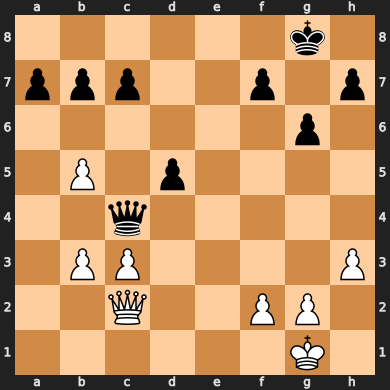

In [11]:
print(vector_to_fen(query_array))
display(chess.Board(fen=query_fen))
print('-'*64)

for ind in top_k_indices:
    fen_array = all_board_csr_matrix[ind]
    fen_string = vector_to_fen(fen_array.toarray()[0])
    print(fen_string)
    display(chess.Board(fen=fen_string))